### 전이학습(Transfer learning)
- 어떤 목적을 이루기 위해 학습된 모델을 다른 작업에 이용하는 것을 말함
- 즉, A문제를 해결하기 위한 모델의 구성을 다른 문제인 B에 이용하는 것으로 볼 수 있음
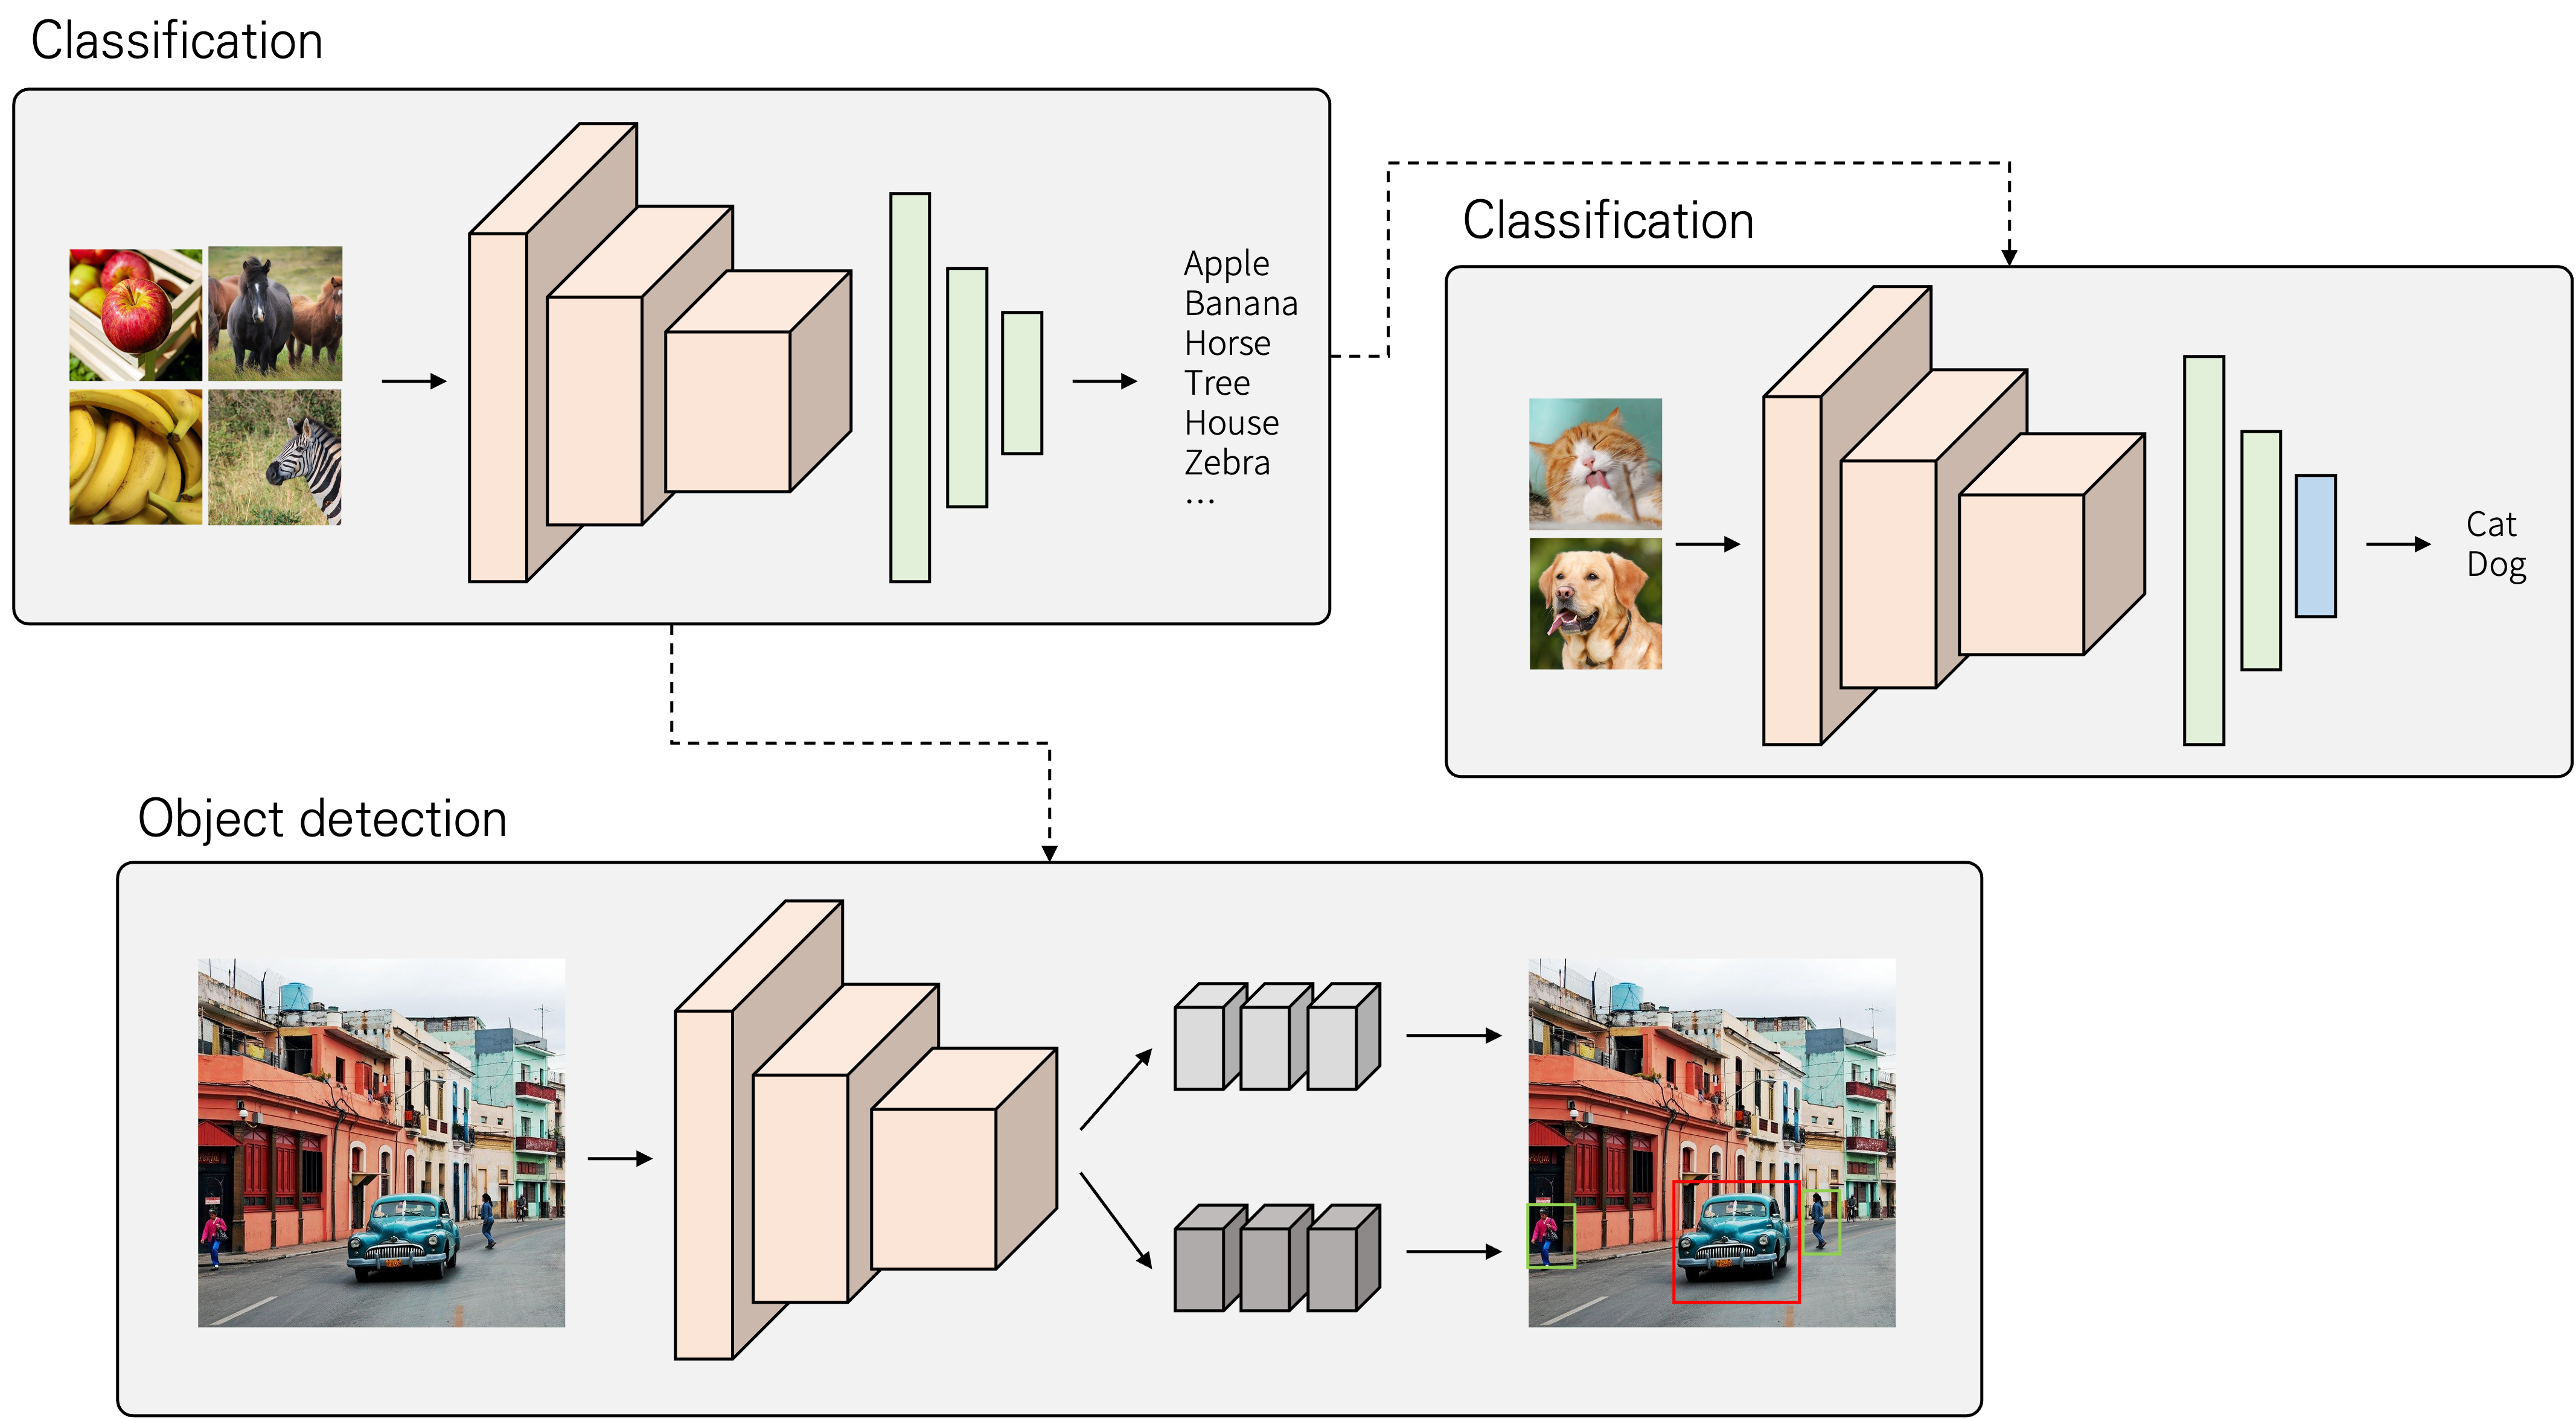
- 위 그림을 예로 설명하면 
    1. 이미지를 학습시켜 분류하는 모델의 구성이 훌륭하다면
    2. 해당 모델을 이용하여 다른 이미지를 학습시켜 분류를 한다거나(dog, cat)
    3. 해당 모델을 발전시켜 이미지내에서 객체를 찾아내는 작업을 할 수 있음

### 사전학습과 미세조정
- 전이 학습을 하기 위해서는 학습된 모델과 새로 학습할 데이터셋이 필요
    - 여기서 학습된 모델을 만드는 과정을 사전 학습(pre-training)이라고 함
    - 미세 조정(fine-tuning)은 사전 학습된 모델을 새로운 문제에 적용하기 위해 일부 가중치를 조절하는 학습 과정을 말한다

- tip. 전이 학습과 미세 조정을 헷갈릴 수 있는데, 전이 학습은 모델을 효율적으로 학습하기 위한 하나의 큰 접근 방법이며, 미세 조정은 전이 학습에서 사용되는 기법 중 하나임

### 전이 학습의 조건
- 사전 학습된 모델은 새로 학습할 데이터에도 적용할 수 있는 지식을 추출할 수 있어야한다.
- 전이 학습이 잘 이루어지기 위해 사전 학습된 모델의 조건은 아래 두 가지가 있음

1. 사전 학습에 사용한 데이터와 새로운 데이터가 비슷한 형태를 가지고, 새로 학습할 데이터에도 비슷한 특징을 활용할 수 있어야 함
    - 즉, 이미지로 사전학습된 모델을 이용해서 이미지 모델링 작업을 해야 함
    - 많이 다른 형태의 데이터를 사전 학습된 모델에 적용한다고 해도 특징의 재추출을 다시 해야 하기 때문에 전이 학습이 효과적이지 못하다

2. 일반적으로 새로운 데이터보다 많은 데이터로 사전 학습이 수행되었어야 함
    - 새로운 데이터가 사전 학습에 사용된 데이터가 많으면, 새로 재 학습 하는 의미가 없어짐
- 이런 이유로 여러 기관이나 혹은 연구소에서 대용량의 데이터로 미리 학습된 알고리즘을 많이 발표하고 있으며, 일반적인 AI 이미지 탐지등의 작업은 미리 알려지고 신뢰된 전이학습 알고리즘을 활용하여 문제를 해결하는 경우가 많다
    - 단, 전이학습 알고리즘들은 개론적인 개념만 제공할 뿐 저작권 문제로 세부 알고리즘 내용은 공개하지 않는것이 일반적이다(API 개념처럼 사용됨)

In [1]:
import zipfile
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

## 새로 학습할 이미지 준비
- 기존 가위 바위 보 이미지

In [3]:
TRAINING_DIR = "./rps/"
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
VALIDATION_DIR = "./rps_test_val/train"
TEST_DIR = "./rps_test_val/val"

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150),
    class_mode='categorical'
)

validation_generator = train_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    class_mode='categorical'
)

test_generator = train_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150,150),
    class_mode='categorical'
)

Found 2520 images belonging to 3 classes.
Found 297 images belonging to 3 classes.
Found 75 images belonging to 3 classes.


### 아래 모델은 CNN을 기반으로 미리 구성되어 학습된 모델
- 전이학습이 아래와 같은 pretrain 모델에 사용자 데이터를 재학습시켜 모델을 구성하는 방법임

- DenseNet 계열
    - 각 계층에, 모든 선행 계층의 (feature-map)형상 맵은 입력으로 사용되며, 자체 형상 맵은 모든 후속 계층에 대한 입력으로 사용됨
        - 계층에서 추출한 모든 특징이 소멸되지 않고 계속 재사용 되어 성능을 높임
    - 장점 : 특징 재사용을 권장하며, 매개 변수의 수를 크게 줄임
- EfficientNet 계열
    - 기존 CNN scaling방법이 depth, width, resolution을 모두 고려하지 않아 정확도나 효율성의 성능이 더 증가하지 않는 문제를 compound scaling 방법을 활용하여 성능을 높인 모델
- VGG 계열
    - CNN을 기본 base로 놓고 convolution layer와 connected layer를 늘려 정확도를 높이고 병렬처리를 가능하게해 연산속도를 높인 모델
- Inception 계열
    - GoogLeNet이라고 불리며 Google에서 연구 발표한 모델 
    - 딥러닝 모델의 성능을 높이는 가장 간단한 방법은 모델(네트워크)의 깊이를 깊고 넓게 만들면 됨

    - 두 가지 큰 문제가 존재
        1. 모델의 사이즈가 커지면, 학습해야 할 파라미터들이 많아지고 이는 과적합으로 이어질 수 있음
        2. 컴퓨팅 파워(컴퓨터 연산의 한계 및 자원 낭비)의 문제가 있음
    - 이 문제를 키워드로 언급한 모델
        - 구글이 발표한 Incaption v1(GoogLeNet)은 AlexNet(기본 CNN)보다 학습할 파라미터의 수는 12배 적지만, 정확도는 훨씬 높음
        - 핵심. Conv Layer를 size 관계없이 한번에 씀
        - 단, VGG 계열 보다 정확도가 높아지지는 않았음
- Resnet 계열
    - Residual neural network의 줄임말
    - 잔차(residual)과 관련이 있음
        - 특정 레이어의 input을 보존시켜 다른 레이어를 통과해서 나온 값에 결합함
            - 이렇게 진행하면 합성곱을 진행시켜 특성으로 단순해진 결과에 기존 값이 결합되므로 손실된 특성을 살릴 수 있음(즉, 특성으로 단순해져서 생기는 오류(잔차)를 더 줄일 수 있음)
- MobileNet/Xception
    - 효율적인 연산을 위해 파라미터를 더 효율적으로 적절히 활용해 depth(layer)를 줄인 경량화 네트워크
    - 이중 MobileNet은 모바일에서 사용가능한 depth를 극단적으로 줄인 가벼운 모델

In [7]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

## 사전학습된 모델 활용 학습 진행 함수 생성

### 사전학습 모델 load 파라미터
- include_top: 네트워크에 FC-layer를 넣을지 말지 Boolean 
    - 커스텀 할지 말지 여부 결정
    - 커스텀 : 전체 구조를 변경하는 과정(사전학습 모델의 구성 중 일부만 차출하고자 할때)
- weights: 구조만 가져오고 싶으면 None, 아니면 default가 'imagenet'이기 때문에 속성 넣지 않기
- input_tensor(shape): 첫번째 Conv2D의 input_shape라 생각하면 됨 (선언 방법: keras.layers.Input(shape=(w, h, c)))
- pooling: include_top이 False일 때 None, avg, max 중 선택
- classes: include_top이 True이고 weights가 None일 때 커스텀으로 구별할 클래스(레이블)의 수. 미세조정이 아닌 전체 구성을 변경하고자 할 때 사용

In [8]:
# 모델 1개를 갖고 와서 입력 설정, 합성곱층은 kwargs를 통해 설정, 출력층 설정

def get_model(model):
# Load the pretained model 기본 파라미터 설정
    kwargs =    {'input_shape':(150,150, 3), #입력차원
                'include_top':False,
                'weights':'imagenet',  # imagenet으로 학습된 가중치 사용, 즉,imagenet db의 이미지를 활용해서 사전학습된 모델을 쓰겠다는 의미
                'pooling':'avg'}  # 컨볼루션의 얻어진 특징을 통계적으로 압축 평균압축방법 사용
    
    pretrained_model = model(**kwargs)  # 사전학습모델 가져오기
    pretrained_model.trainable = False  # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input # 사전학습된 모델의 input 설정 추출

    # 미세조정(기본 미세조정) : dense 층 추가
    # 최종 분류를 위해서는 기본 신경망이 필요하고 사전 학습 모델은 합성곱층까지만 제공됨
    # (pretrained_model.output)을 새로 추가하는 Dense층의 input으로 전달
    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    # x = 사전학습된 모델의 합성곱층과 분석가가가 미세조정한 2개의 dense 층이 포함된 층 (layer)

    # 재학습 객체에 따른 출력층 추가
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
    # 라벨 개수가 3개이기 때문에 Dense도 3로 설정
    
    # Model 객체 생성
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    # 사전학습 모델에 대하여 ipust, output 설정 후 모델 구성
    # model객체 : input층-사전학습된 합성곱층-분석가의 미세조정 밀집층-출력층
    
    model.compile(
        optimizer='RMSprop',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### VGG16에 미세조정 더한 모델 구성 확인

In [9]:
model = get_model(tf.keras.applications.VGG16)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

### 사전학습과 미세조정을 거친 모델을 활용한 기본 학습

In [10]:
# Train모델 학습
for name, model in models.items():
    
    # 전이 학습 모델 가져오기
    m = get_model(model['model'])
    models[name]['model'] = m  # 사용자가 생성한 딕셔너리에 모델객체 추가
    
    start = perf_counter()  # 학습 시간 측정을 위한 객체 생성 (학습시간 체크)
    
    # 모델 학습
    history = m.fit(train_generator,validation_data=validation_generator,epochs=1,verbose=0)
    
    # 학습시간과 val_accuracy 저장
    duration = perf_counter() - start  # 학습 소요시간 측정
    duration = round(duration,2)
    models[name]['perf'] = duration  # model dict에 소요시간 저장
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]  # 모델 검증정확도 저장

DenseNet121          trained in 30.97 sec
MobileNetV2          trained in 22.17 sec
DenseNet201          trained in 32.98 sec


2023-09-12 03:13:26.233470: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


EfficientNetB0       trained in 25.25 sec


2023-09-12 03:13:55.155334: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


EfficientNetB1       trained in 27.02 sec
InceptionV3          trained in 25.26 sec
12683000/12683000 [==============================] - 1s 0us/step
MobileNetV3Large     trained in 23.06 sec
ResNet152V2          trained in 30.67 sec
ResNet50             trained in 22.58 sec
94668760/94668760 [==============================] - 4s 0us/step
ResNet50V2           trained in 21.92 sec
80134624/80134624 [==============================] - 3s 0us/step
VGG19                trained in 35.82 sec
VGG16                trained in 19.61 sec
83683744/83683744 [==============================] - 3s 0us/step
Xception             trained in 24.67 sec


- 완료된 내용

In [11]:
models

{'DenseNet121': {'model': <keras.engine.functional.Functional at 0x7f1b3f58c3a0>,
  'perf': 30.97,
  'val_acc': [0.9293]},
 'MobileNetV2': {'model': <keras.engine.functional.Functional at 0x7f172ae03dc0>,
  'perf': 22.17,
  'val_acc': [0.8956]},
 'DenseNet201': {'model': <keras.engine.functional.Functional at 0x7f172a634a00>,
  'perf': 32.98,
  'val_acc': [0.9394]},
 'EfficientNetB0': {'model': <keras.engine.functional.Functional at 0x7f16e40fa760>,
  'perf': 25.25,
  'val_acc': [0.3333]},
 'EfficientNetB1': {'model': <keras.engine.functional.Functional at 0x7f16d5ad6b20>,
  'perf': 27.02,
  'val_acc': [0.3333]},
 'InceptionV3': {'model': <keras.engine.functional.Functional at 0x7f16a77b9d90>,
  'perf': 25.26,
  'val_acc': [0.8923]},
 'MobileNetV3Large': {'model': <keras.engine.functional.Functional at 0x7f16a0d3f400>,
  'perf': 23.06,
  'val_acc': [0.3838]},
 'ResNet152V2': {'model': <keras.engine.functional.Functional at 0x7f169854b5e0>,
  'perf': 30.67,
  'val_acc': [0.6094]},
 'Res

In [12]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    t = models[name]['model'].evaluate(test_generator)
    models[name]['acc']=t[1]
    print(f'**{name} has a {t[1] * 100:.2f}% accuracy on the test set**')

3/3 [==============================] - 1s 585ms/step - loss: 0.2008 - accuracy: 0.9333
**DenseNet121 has a 93.33% accuracy on the test set**
3/3 [==============================] - 1s 247ms/step - loss: 0.2438 - accuracy: 0.9067
**MobileNetV2 has a 90.67% accuracy on the test set**
3/3 [==============================] - 1s 584ms/step - loss: 0.0586 - accuracy: 1.0000
**DenseNet201 has a 100.00% accuracy on the test set**
3/3 [==============================] - 1s 256ms/step - loss: 1.0987 - accuracy: 0.3333
**EfficientNetB0 has a 33.33% accuracy on the test set**
3/3 [==============================] - 1s 186ms/step - loss: 1.1067 - accuracy: 0.3333
**EfficientNetB1 has a 33.33% accuracy on the test set**
3/3 [==============================] - 1s 471ms/step - loss: 0.3451 - accuracy: 0.8667
**InceptionV3 has a 86.67% accuracy on the test set**
3/3 [==============================] - 1s 244ms/step - loss: 1.0936 - accuracy: 0.4667
**MobileNetV3Large has a 46.67% accuracy on the test set**
3

### 모델별 성과 df 생성

In [13]:
#  Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet201,0.9394,1.000000,32.98
1,VGG16,0.9158,0.973333,19.61
2,DenseNet121,0.9293,0.933333,30.97
3,MobileNetV2,0.8956,0.906667,22.17
4,ResNet50V2,0.9057,0.893333,21.92
5,InceptionV3,0.8923,0.866667,25.26
6,VGG19,0.8384,0.826667,35.82
7,Xception,0.7205,0.746667,24.67
8,ResNet152V2,0.6094,0.573333,30.67
9,MobileNetV3Large,0.3838,0.466667,23.06


### 위 결과를 보면 VGG16 모델이 가장 성능이 좋았음 (단, 학습시간이 오래걸림)
- 해당 모델로 epochs 늘려서 재학습

In [16]:
# 속도가 너무 느리므로 MobileNetV2를 활용해보는게 좋을 듯
model = get_model(tf.keras.applications.VGG16)
history = model.fit(train_generator,validation_data=validation_generator,
                    epochs=2)

Epoch 1/2
79/79 [==============================] - 19s 233ms/step - loss: 0.4827 - accuracy: 0.8290 - val_loss: 0.1813 - val_accuracy: 0.9663
Epoch 2/2
79/79 [==============================] - 18s 229ms/step - loss: 0.1442 - accuracy: 0.9587 - val_loss: 0.2945 - val_accuracy: 0.9057


## 모델 테스트

In [17]:
import sys
sample_images = ['./image/rsp_image_{}.jpg'.format(i) for i in range(1,4)]
sample_images.append('./image/rsp_image_4.png')
sample_images

['./image/rsp_image_1.jpg',
 './image/rsp_image_2.jpg',
 './image/rsp_image_3.jpg',
 './image/rsp_image_4.png']

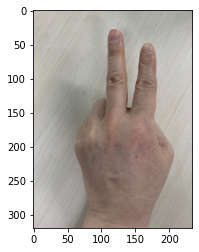

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 1s 734ms/step
./image/rsp_image_1.jpg는 가위입니다.


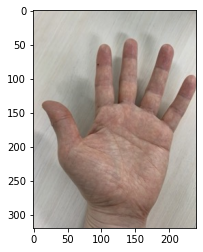

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 20ms/step
./image/rsp_image_2.jpg는 바위입니다.


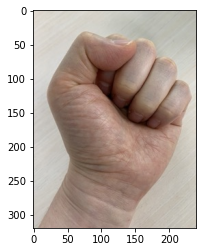

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 20ms/step
./image/rsp_image_3.jpg는 바위입니다.


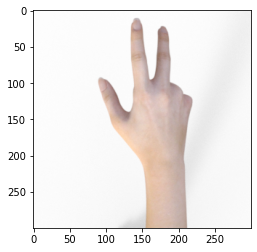

(150, 150, 3)
(1, 150, 150, 3)
1/1 [==============================] - 0s 20ms/step
./image/rsp_image_4.png는 가위입니다.


In [18]:
rsp_name = ['보', '바위', '가위']

for fn in sample_images:
    # 이미지 출력
    plt.imshow(mpimg.imread(fn))
    plt.show()
    
    # 이미지 불러오기
    img = tf.keras.utils.load_img(fn, target_size=(150, 150))
    x = tf.keras.utils.img_to_array(img) # 학습시에는 generator가 실행했음
    print(x.shape)
    x = np.expand_dims(x, axis=0) # 이미지는 3차원 입력은 4차원 배열이어야 함
    print(x.shape)

    classes = model.predict(x)

    idx = np.argmax(classes[0])
    print(fn + "는 {}입니다.".format(rsp_name[idx]))

## 전이학습을 활용하면 이미 구성되고 검증된 모델을 활용하므로 어느정도 신뢰되는 성능의 모델을 얻을 수 있다